In [1]:
#################################################################
## We need Altair, Pandas, and JSON packages.
## For computing TF-IDF, we need scikit-learn, however, we only
## import that inside showTopWords(). You will need to install
## scikit-learn if you'd like to run the second visualization.
#################################################################
import altair as alt
import pandas as pd
import json
import os

alt.renderers.enable('notebook')

In [2]:
def loadData():
    """
    Load from prof vo's github
    """
    import os
    import urllib.request, json 
    json_data = 'https://raw.githubusercontent.com/hvo/' + \
                'datasets/master/nyc_restaurants_by_cuisine.json'
    with urllib.request.urlopen(json_data) as url:
        data = json.loads(url.read().decode())
        restaurants_df = pd.io.json.json_normalize(data)
    return restaurants_df

data = loadData()
data.head()

,cuisine,perZip.10001,perZip.10002,perZip.10003,perZip.10004,perZip.10005,perZip.10006,perZip.10007,perZip.10009,perZip.10010,...,perZip.11434,perZip.11435,perZip.11436,perZip.11451,perZip.11691,perZip.11692,perZip.11693,perZip.11694,perZip.11697,total
0,American,2249.0,1651.0,2483.0,585.0,318.0,277.0,586.0,1635.0,1295.0,...,207.0,349.0,96.0,32.0,35.0,NaN,128.0,115.0,46.0,84995
1,Chinese,209.0,1976.0,467.0,29.0,13.0,61.0,8.0,135.0,164.0,...,196.0,267.0,64.0,NaN,154.0,11.0,51.0,104.0,NaN,39515
2,Pizza,201.0,343.0,293.0,75.0,37.0,27.0,108.0,210.0,180.0,...,107.0,63.0,18.0,NaN,120.0,15.0,15.0,65.0,NaN,17640
3,Latin,67.0,111.0,52.0,59.0,NaN,NaN,NaN,219.0,41.0,...,NaN,227.0,NaN,NaN,114.0,NaN,31.0,17.0,NaN,17400
4,Italian,113.0,155.0,611.0,103.0,25.0,NaN,66.0,158.0,162.0,...,NaN,14.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,16699


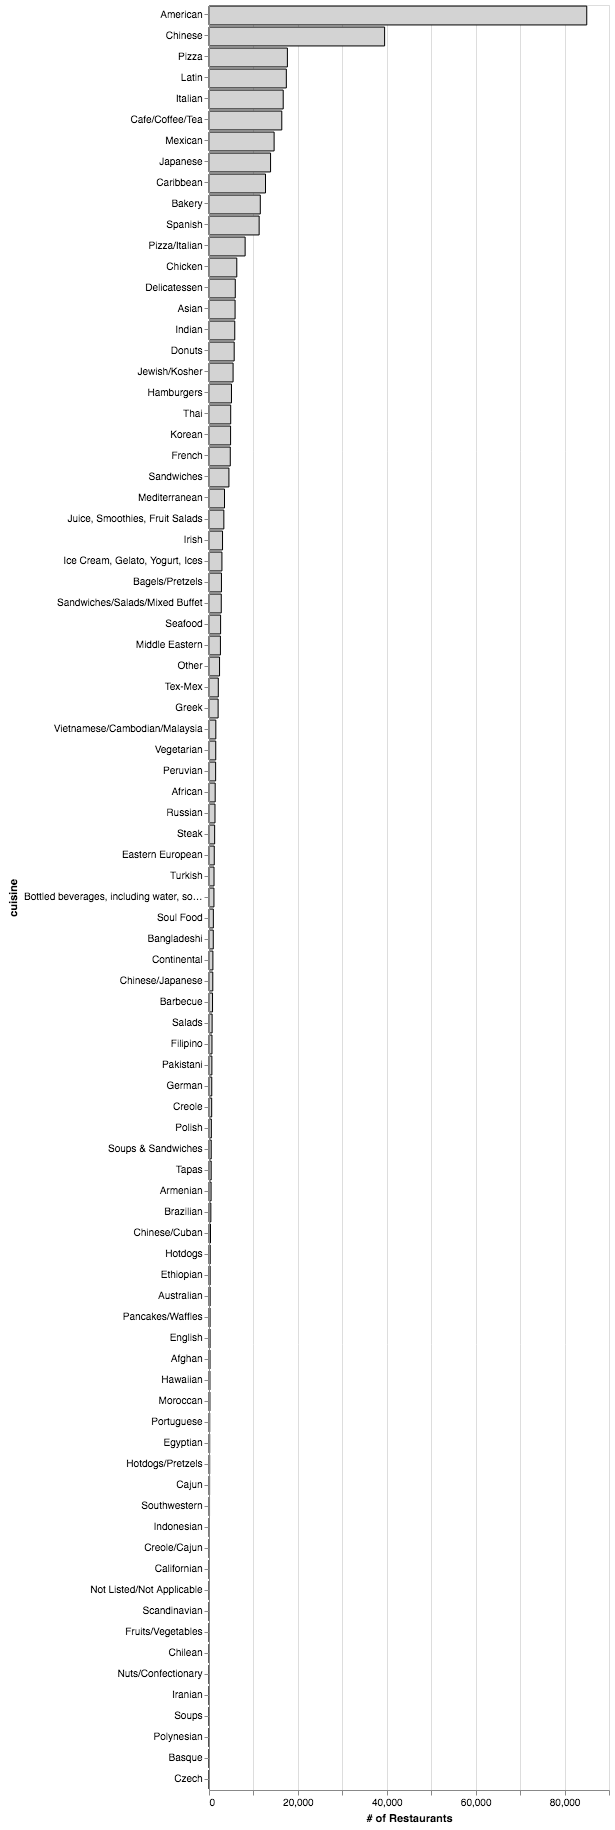

In [3]:
def showViz(data, zip_code):
    color_expression = "(indexof(lower(datum.cuisine),search.term)>=0) \
                         || (highlight._vgsid_==datum._vgsid_)"
    color_condition = alt.ConditionalPredicateValueDef(color_expression, 
                                                       'SteelBlue')
    highlight_selection = alt.selection_single(name='highlight', on='mouseover', 
                                               empty='none')
    search_selection = alt.selection_single(name='search', on='mouseover', 
                                            empty='none', fields=["term"],
                                            bind=alt.VgGenericBinding('input'))

    vizualization = alt.Chart(data) \
        .mark_bar(stroke='Black') \
        .encode(
            alt.X('total:Q', axis=alt.Axis(title='# of Restaurants')),
            alt.Y('cuisine:O', sort=alt.SortField(field='total', op='argmax')),
            alt.ColorValue('LightGrey', condition=color_condition),
            ).properties(
                selection=(highlight_selection + search_selection),
                )
    return vizualization

showViz(data, 11238)

In [ ]:
from flask import Flask, Response
from analysis import loadData, showViz
data = loadData()
app = Flask(__name__, static_url_path='', static_folder='.')
app.add_url_rule('/', 'root', lambda: app.send_static_file('index.html'))

@app.route('/vis/<platform>/<int:rating>')
def visualize(zip_code):
    '''
    Returns a flask visualization by filtering the data by zip-code
    '''
    df = data
    zip_filtered = df[['cuisine','perZip.' + str(zip_code)]]
    zip_filtered.rename(columns={'perZip.' + str(zip_code): 'total'}, inplace=True)
    zip_filtered = zip_filtered.dropna(axis=0, how='any') # Remove n/a values
    
    # Top 25
    zip_filtered = zip_filtered.sort_values(by=['total'], ascending=False)[:25][['cuisine', 'total']]
    response = '' # In case of errors return blank
    if zip_filtered is not None:
        response = showViz(zip_filtered, zip_code).to_json()

    return Response(response,
        mimetype='application/json',
        headers={
            'Cache-Control': 'no-cache',
            'Access-Control-Allow-Origin': '*'
        }
    )

if __name__ == '__main__':
    app.run(port=8000)

 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)
